In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
infile = open("test.pkl",'rb')
testset = pickle.load(infile)
infile.close()

In [3]:
for img_id in range(testset.shape[0]):
    testset[img_id] = (testset[img_id] - torch.min(testset[img_id])) / (torch.max(testset[img_id]) - torch.min(testset[img_id]))

noisy_testset15 = testset + (15 / 255) * np.random.randn(100*1600,40,40)
noisy_testset25 = testset + (25 / 255) * np.random.randn(100*1600,40,40)
noisy_testset50 = testset + (50 / 255) * np.random.randn(100*1600,40,40)

In [4]:
testing_data15 = []
for i, img in enumerate(noisy_testset15):
    testing_data15.append((img[None,:,:], testset[i,None,:,:]))
    
testing_data25 = []
for i, img in enumerate(noisy_testset25):
    testing_data25.append((img[None,:,:], testset[i,None,:,:]))
    
testing_data50 = []
for i, img in enumerate(noisy_testset50):
    testing_data50.append((img[None,:,:], testset[i,None,:,:]))

In [5]:
load15 = torch.utils.data.DataLoader(testing_data15,batch_size=128,shuffle=False)
load25 = torch.utils.data.DataLoader(testing_data25,batch_size=128,shuffle=False)
load50 = torch.utils.data.DataLoader(testing_data50,batch_size=128,shuffle=False)

In [6]:
N=100

In [7]:
dict15_D15 = torch.load("dncnn_noise_15_D15.pt")
dict25_D15 = torch.load("dncnn_noise_25_D15.pt")
dict50_D15 = torch.load("dncnn_noise_50_D15.pt")

dict15_D20 = torch.load("dncnn_noise_15_D20.pt")
dict25_D20 = torch.load("dncnn_noise_25_D20.pt")
dict50_D20 = torch.load("dncnn_noise_50_D20.pt")

In [8]:
from torch import nn
N=128
class loss(nn.Module): #N is dataset size
  def __init__(self):
    super(loss,self).__init__()
  def forward(self,out,y,x):
    return torch.norm(out-(y-x))/(2*N) #Where does N get defined?
criterion=loss()

In [9]:
#Write PSNR of output code here
class PSNR_f(nn.Module):
    def __init__(self):
        super(PSNR_f,self).__init__()
    def forward(self,output,clean):
        MSE=torch.mean(torch.norm(output-clean))
        value=10*torch.log10(255**2/MSE)
        return value
PSNR=PSNR_f()

In [10]:
def test(net, loader):
    test_loss=0
    PSNR_value=0
    denoised_imgs = []
    noisy_imgs = []
    clean_imgs = []
    
    net.eval()
    with torch.no_grad():
        for noisy, clean in loader:
            noisy = noisy.to(device, dtype=torch.float)
            clean = clean.to(device, dtype=torch.float)
            prediction = net(noisy)
            denoise = noisy - prediction

            batch_loss = criterion(prediction, noisy, clean)
            batch_PSNR = PSNR(denoise, clean)
            PSNR_value += batch_PSNR.item()
            test_loss += batch_loss.item()

            denoised_imgs.append(denoise.cpu().detach().numpy())
            noisy_imgs.append(noisy.cpu().detach().numpy())
            clean_imgs.append(clean.cpu().detach().numpy())
        
    PSNR_value = PSNR_value/len(loader)
    test_loss  = test_loss/len(loader)
    
    print("   Test loss is {:.3f}".format(test_loss))
    print("   PSNR value is {:.3f}".format(PSNR_value))
    
    return clean_imgs, noisy_imgs, denoised_imgs

In [11]:
import import_ipynb
import DnCNN_IVP

importing Jupyter notebook from DnCNN_IVP.ipynb


In [12]:
device=torch.device('cuda:0')
model15_D15=DnCNN_IVP.DnCNN(1,1,15).to(device)
model15_D15.load_state_dict(dict15_D15)

model15_D20=DnCNN_IVP.DnCNN(1,1,20).to(device)
model15_D20.load_state_dict(dict15_D20)

model25_D15=DnCNN_IVP.DnCNN(1,1,15).to(device)
model25_D15.load_state_dict(dict25_D15)

model25_D20=DnCNN_IVP.DnCNN(1,1,20).to(device)
model25_D20.load_state_dict(dict25_D20)

model50_D15=DnCNN_IVP.DnCNN(1,1,15).to(device)
model50_D15.load_state_dict(dict50_D15)

model50_D20=DnCNN_IVP.DnCNN(1,1,20).to(device)
model50_D20.load_state_dict(dict50_D20)

<All keys matched successfully>

For model:  model15_D15  and dataset:  load15
   Test loss is 0.137
   PSNR value is 32.724
For model:  model15_D15  and dataset:  load25
   Test loss is 0.195
   PSNR value is 31.168
For model:  model15_D15  and dataset:  load50
   Test loss is 0.356
   PSNR value is 28.536


For model:  model15_D20  and dataset:  load15
   Test loss is 0.448
   PSNR value is 27.540
For model:  model15_D20  and dataset:  load25
   Test loss is 0.468
   PSNR value is 27.341
For model:  model15_D20  and dataset:  load50
   Test loss is 0.556
   PSNR value is 26.594


For model:  model25_D15  and dataset:  load15
   Test loss is 0.444
   PSNR value is 27.571
For model:  model25_D15  and dataset:  load25
   Test loss is 0.471
   PSNR value is 27.318
For model:  model25_D15  and dataset:  load50
   Test loss is 0.563
   PSNR value is 26.543


For model:  model25_D20  and dataset:  load15
   Test loss is 0.104
   PSNR value is 33.863
For model:  model25_D20  and dataset:  load25
   Test loss is 0.174
   PSN

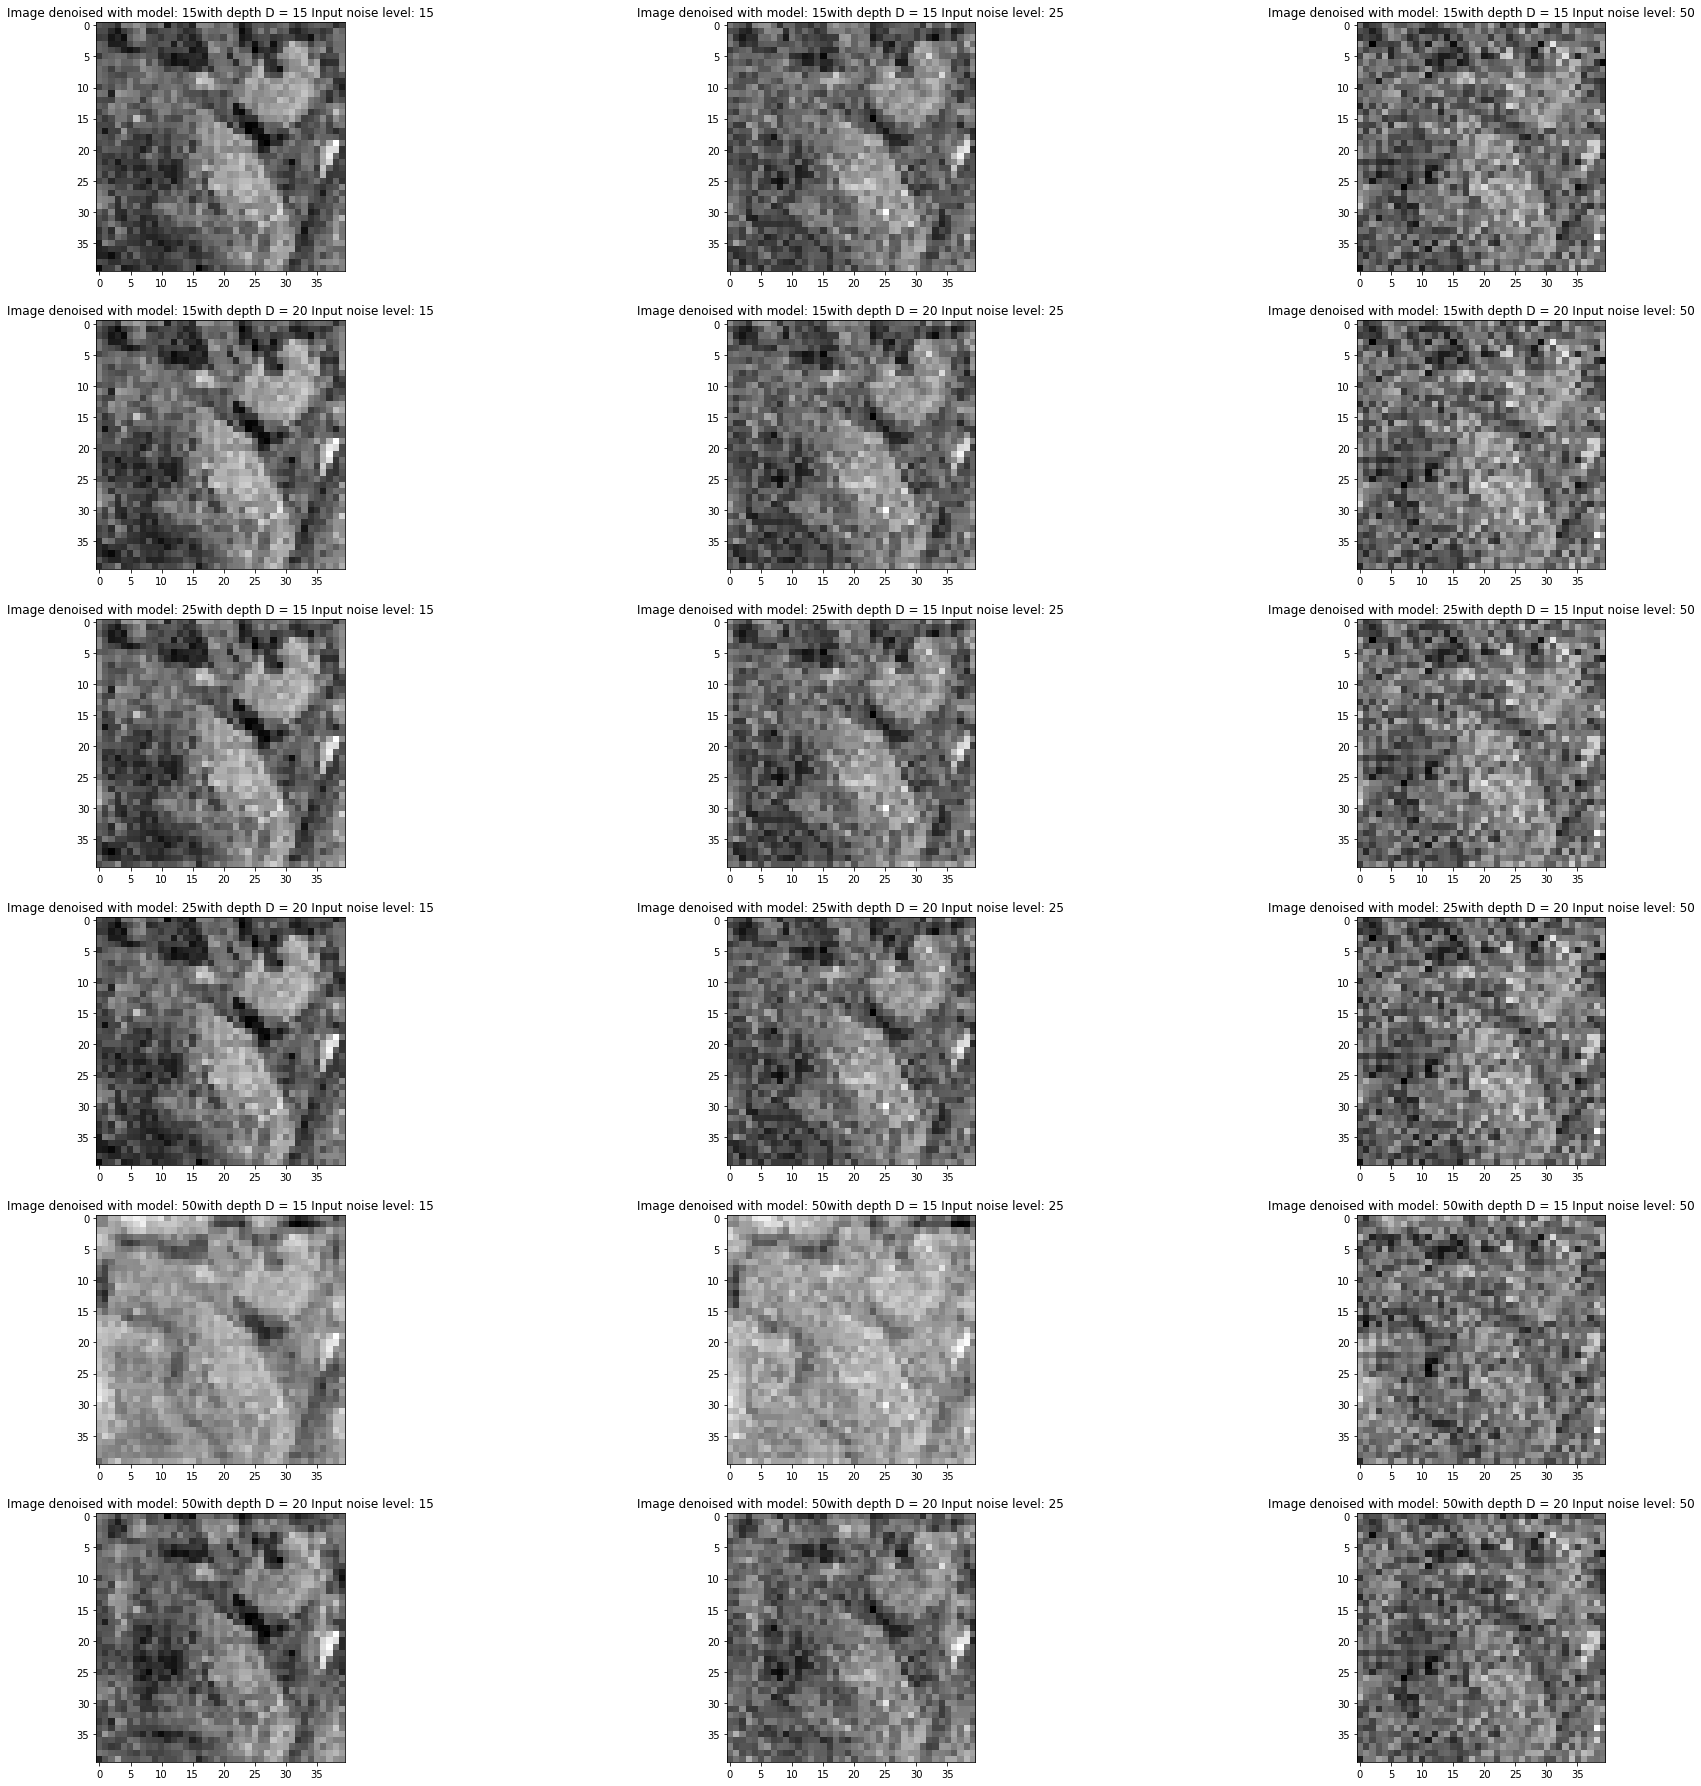

In [13]:
model_dict={}
model_dict[model15_D15]="model15_D15"
model_dict[model15_D20]="model15_D20"
model_dict[model25_D15]="model25_D15"
model_dict[model25_D20]="model25_D20"
model_dict[model50_D15]="model50_D15"
model_dict[model50_D20]="model50_D20"

load_dict={}
load_dict[load15]= "load15"
load_dict[load25]= "load25"
load_dict[load50]= "load50"

plt.figure(figsize=(32,32))
loop = 1

for m in model_dict:
    for l in load_dict:
        print("For model: ",model_dict[m]," and dataset: ", load_dict[l])
        _, _, denoise = test(m,l)
        
        plt.subplot(6,3,loop)
        plt.imshow(denoise[0][0][0], cmap='gray')
        plt.title("Image denoised with model: " + model_dict[m][5:7] + "with depth D = " + model_dict[m][-2:] + " Input noise level: " + load_dict[l][-2:])
        
        loop += 1
        
    print("\n")

In [27]:
depth_to_noise = {}

for file in os.listdir('./training_loss'):
    loss_val_list = []
    with open('./training_loss/' + file, 'r') as f:
        depth = int(file[-6:-4])
        noise_level = int(file[-10:-8])
        
        for loss_val in f:
            loss_val_list.append(float(loss_val))
    
    depth_to_noise[(depth, noise_level)] = loss_val_list

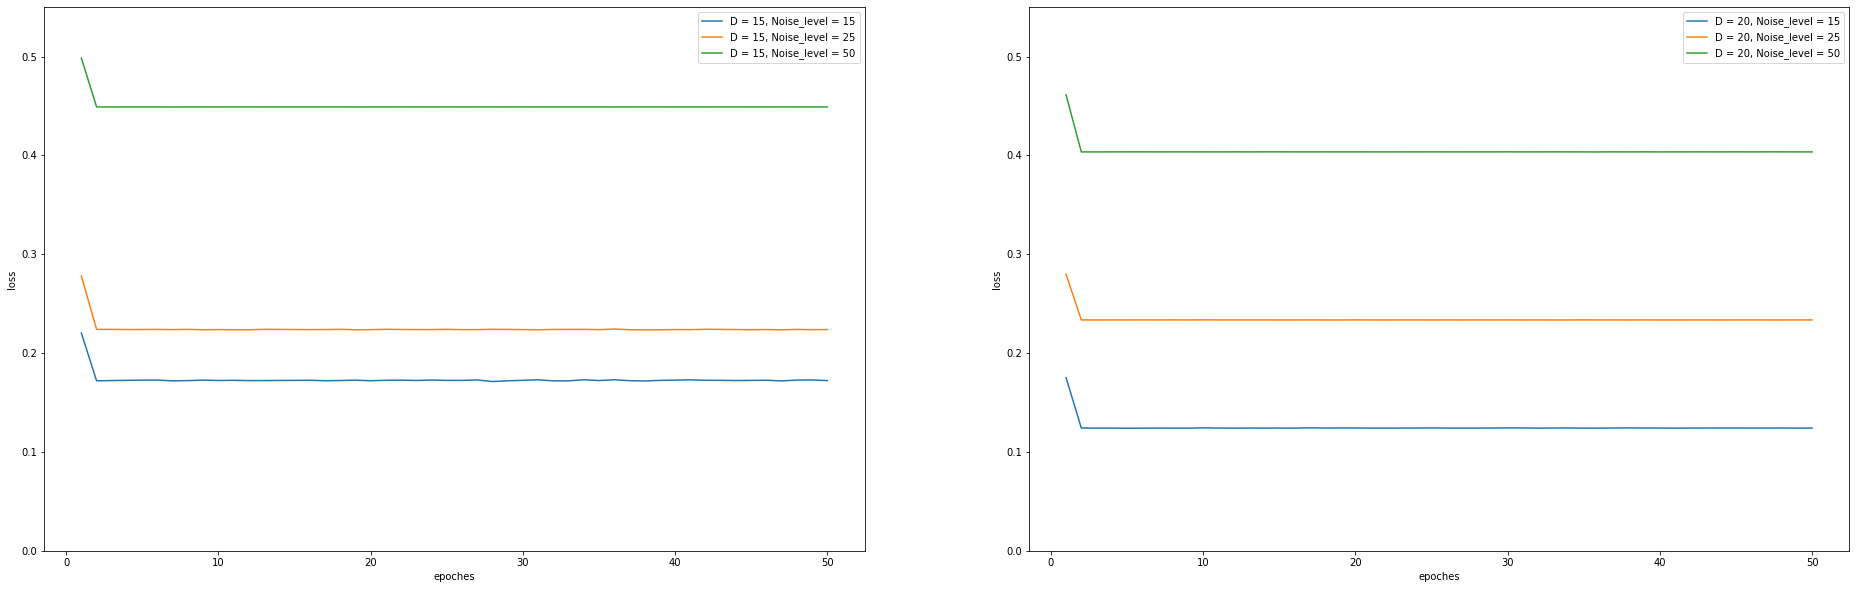

In [35]:
# plotting the training loss
plt.figure(figsize=(50, 10))
loop = 1
for d in [15, 20]:
    plt.subplot(1, 3, loop)
    loop += 1
    for n in [15, 25, 50]:
        plt.plot(np.arange(1,51), depth_to_noise[(d, n)], label='D = ' + str(d) + ', Noise_level = ' + str(n))
    plt.legend()
    plt.xlabel('epoches')
    plt.ylabel('loss')
    plt.ylim([0,0.55])